In [173]:
from IPython.display import Image, display

In [179]:
from typing import List, Annotated, TypedDict, operator, Literal
from pydantic import BaseModel, Field

from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langchain_core.runnables import RunnableConfig
from langgraph.graph import MessagesState
from langchain_tavily import TavilySearch

from langgraph.types import Command, Send
from langgraph.graph import START, END, StateGraph

from open_deep_research.configuration import Configuration
from open_deep_research.utils import get_config_value, select_and_execute_search

## Tools factory - will be initialized based on configuration
def get_search_tool(config: RunnableConfig):
    """Get the appropriate search tool based on configuration"""
    configurable = Configuration.from_runnable_config(config)
    search_api = get_config_value(configurable.search_api)
    
    # Default to Tavily if not specified
    if search_api.lower() == "tavily":
        return TavilySearch(
            max_results=5,
            topic="general",
            include_raw_content=True
        )
    else:
        # For other search APIs, we'll use select_and_execute_search in the research agent
        # This is a placeholder tool that will be replaced in execution
        return TavilySearch(
            max_results=5,
            topic="general",
            include_raw_content=True
        )

@tool
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Research scope for this section of the report.",
    )
    content: str = Field(
        description="The content of the section."
    )

@tool
class Sections(BaseModel):
    sections: List[str] = Field(
        description="Sections of the report.",
    )

@tool
class Introduction(BaseModel):
    name: str = Field(
        description="Name for the report.",
    )
    content: str = Field(
        description="The content of the introduction, giving an overview of the report."
    )

@tool
class Conclusion(BaseModel):
    name: str = Field(
        description="Name for the conclusion of the report.",
    )
    content: str = Field(
        description="The content of the conclusion, summarizing the report."
    )

## State
class ReportStateOutput(TypedDict):
    final_report: str # Final report

class ReportState(MessagesState):
    sections: list[str] # List of report sections 
    completed_sections: Annotated[list, operator.add] # Send() API key
    final_report: str # Final report

class SectionState(MessagesState):
    section: str # Report section  
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

class SectionOutputState(TypedDict):
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

## Supervisor
SUPERVISOR_INSTRUCTIONS = """
You are scoping research for a report based on a user-provided topic.

### Your responsibilities:

1. **Gather Background Information**  
   Based upon the user's topic, use the `tavily_search_tool` to collect relevant information about the topic. 
   - You MUST perform at least  1 search to gather comprehensive context
   - Take time to analyze and synthesize the search results before proceeding
   - Do not proceed to the next step until you have an understanding of the topic

2. **Clarify the Topic**  
   After your initial research, engage with the user to clarify any questions that arose.
   - Ask specific follow-up questions based on what you learned from your searches
   - Do not proceed until you fully understand the topic, goals, constraints, and any preferences
   - Synthesize what you've learned so far before asking questions
   - You MUST engage in at least one clarification exchange with the user before proceeding

3. **Define Report Structure**  
   Only after completing both research AND clarification with the user:
   - Use the `Sections` tool to define a list of report sections
   - Each section should be a written description with: a section name and a section research plan
   - Do not include sections for introductions or conclusions (We'll add these later)
   - Ensure sections are scoped to be independently researchable
   - Base your sections on both the search results AND user clarifications

4. **Assemble the Final Report**  
   When all sections are returned:
   - IMPORTANT: First check your previous messages to see what you've already completed
   - If you haven't created an introduction yet, use the `Introduction` tool to generate one
     - Set content to include report title with a single # (H1 level) at the beginning
     - Example: "# [Report Title]\n\n[Introduction content...]"
   - After the introduction, use the `Conclusion` tool to summarize key insights
     - Set content to include conclusion title with ## (H2 level) at the beginning
     - Example: "## Conclusion\n\n[Conclusion content...]"
   - Do not call the same tool twice - check your message history

### Additional Notes:
- You are a reasoning model. Think through problems step-by-step before acting.
- IMPORTANT: Do not rush to create the report structure. Gather information thoroughly first.
- Use multiple searches to build a complete picture before drawing conclusions.
- Maintain a clear, informative, and professional tone throughout."""

RESEARCH_INSTRUCTIONS = """
You are a researcher responsible for completing a specific section of a report.

### Your goals:

1. **Understand the Section Scope**  
   Begin by reviewing the section name and description. This defines your research focus. Use it as your objective.


<Section Description>
{section_description}
</Section Description>

2. **Research the Topic**  
   Use the `tavily_search_tool` to gather relevant information and evidence. Search iteratively if needed to fully understand the section's scope.
   - Save the URLs from your searches - you will need to cite them later
   - Aim to gather information from at least 3 different sources

3. **Use the Section Tool**  
   Once you've gathered sufficient context, write a high-quality section using the Section tool:
   - `name`: The title of the section
   - `description`: The scope of research you completed (brief, 1-2 sentences)
   - `content`: The completed body of text for the section, which MUST:
     - Begin with the section title formatted as "## [Section Title]" (H2 level with ##)
     - Be formatted in Markdown style
     - Be MAXIMUM 200 words (strictly enforce this limit)
     - End with a "### Sources" subsection (H3 level with ###) containing a numbered list of URLs used
     - Use clear, concise language with bullet points where appropriate
     - Include relevant facts, statistics, or expert opinions

Example format for content:
```
## [Section Title]

[Body text in markdown format, maximum 200 words...]

### Sources
1. [URL 1]
2. [URL 2]
3. [URL 3]
```

---

### Reasoning Guidance

You are a reasoning model. Think through the task step-by-step before writing. Break down complex questions. If you're unsure about something, search again.

- You may reason internally before producing content.
- Your job is not to summarize randomly—it's to **research and synthesize a strong, scoped contribution** to a report.
- Always track and cite your sources.
- Be concise - stay within the 200 word limit for the main content.

---

### Notes:
- Do not write introductions or conclusions unless explicitly part of your section.
- Keep a professional, factual tone.
- If you do not have enough information to complete the section, search again or clarify your approach before continuing.
- Always follow markdown formatting.
"""

# Tool lists will be built dynamically based on configuration
def get_supervisor_tools(config: RunnableConfig):
    """Get supervisor tools based on configuration"""
    search_tool = get_search_tool(config)
    tool_list = [search_tool, Sections, Introduction, Conclusion]
    return tool_list, {tool.name: tool for tool in tool_list}

def get_research_tools(config: RunnableConfig):
    """Get research tools based on configuration"""
    search_tool = get_search_tool(config)
    tool_list = [search_tool, Section]
    return tool_list, {tool.name: tool for tool in tool_list}

def supervisor(state: ReportState, config: RunnableConfig):
    """LLM decides whether to call a tool or not"""

    # Messages
    messages = state["messages"]

    # Get configuration
    configurable = Configuration.from_runnable_config(config)
    supervisor_model = get_config_value(configurable.supervisor_model)
    
    # Initialize the model
    llm = init_chat_model(model=supervisor_model)
    
    # If sections have been completed, but we don't yet have the final report, then we need to initiate writing the introduction and conclusion
    if state.get("completed_sections") and not state.get("final_report"):
        research_complete_message = {"role": "user", "content": "Research is complete. Now write the introduction and conclusion for the report. Here are the completed main body sections: \n\n" + "\n\n".join([s.content for s in state["completed_sections"]])}
        messages = messages + [research_complete_message]

    # Get tools based on configuration
    supervisor_tool_list, _ = get_supervisor_tools(config)
    
    # Invoke
    return {
        "messages": [
            llm.bind_tools(supervisor_tool_list).invoke(
                [
                    {"role": "system",
                     "content": SUPERVISOR_INSTRUCTIONS,
                    }
                ]
                + messages
            )
        ]
    }

def supervisor_tools(state: ReportState, config: RunnableConfig)  -> Command[Literal["supervisor", "research_team", "__end__"]]:
    """Performs the tool call and sends to the research agent"""

    result = []
    sections_list = []
    intro_content = None
    conclusion_content = None

    # Get tools based on configuration
    _, supervisor_tools_by_name = get_supervisor_tools(config)
    
    # First process all tool calls to ensure we respond to each one (required for OpenAI)
    for tool_call in state["messages"][-1].tool_calls:
        # Get the tool
        tool = supervisor_tools_by_name[tool_call["name"]]
        # Perform the tool call
        observation = tool.invoke(tool_call["args"])

        # Append to messages 
        result.append({"role": "tool", 
                       "content": observation, 
                       "name": tool_call["name"], 
                       "tool_call_id": tool_call["id"]})
        
        # Store special tool results for processing after all tools have been called
        if tool_call["name"] == "Sections":
            sections_list = observation.sections
        elif tool_call["name"] == "Introduction":
            # Format introduction with proper H1 heading if not already formatted
            if not observation.content.startswith("# "):
                intro_content = f"# {observation.name}\n\n{observation.content}"
            else:
                intro_content = observation.content
        elif tool_call["name"] == "Conclusion":
            # Format conclusion with proper H2 heading if not already formatted
            if not observation.content.startswith("## "):
                conclusion_content = f"## {observation.name}\n\n{observation.content}"
            else:
                conclusion_content = observation.content
    
    # After processing all tool calls, decide what to do next
    if sections_list:
        # Send the sections to the research agents
        return Command(goto=[Send("research_team", {"section": s}) for s in sections_list], update={"messages": result})
    elif intro_content:
        # Store introduction while waiting for conclusion
        # Append to messages to guide the LLM to write conclusion next
        result.append({"role": "user", "content": "Introduction written. Now write a conclusion section."})
        return Command(goto="supervisor", update={"final_report": intro_content, "messages": result})
    elif conclusion_content:
        # Get all sections and combine in proper order: Introduction, Body Sections, Conclusion
        intro = state.get("final_report", "")
        body_sections = "\n\n".join([s.content for s in state["completed_sections"]])
        
        # Assemble final report in correct order
        complete_report = f"{intro}\n\n{body_sections}\n\n{conclusion_content}"
        
        # Append to messages to indicate completion
        result.append({"role": "user", "content": "Report is now complete with introduction, body sections, and conclusion."})
        return Command(goto="supervisor", update={"final_report": complete_report, "messages": result})
    else:
        # Default case (for search tools, etc.)
        return Command(goto="supervisor", update={"messages": result})

def supervisor_should_continue(state: ReportState) -> Literal["supervisor_tools", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "supervisor_tools"
    
    # Else end because the supervisor asked a question or is finished
    else:
        return END

def research_agent(state: SectionState, config: RunnableConfig):
    """LLM decides whether to call a tool or not"""
    
    # Get configuration
    configurable = Configuration.from_runnable_config(config)
    researcher_model = get_config_value(configurable.researcher_model)
    
    # Initialize the model
    llm = init_chat_model(model=researcher_model)

    # Get tools based on configuration
    research_tool_list, _ = get_research_tools(config)
    
    return {
        "messages": [
            # Enforce tool calling to either perform more search or call the Section tool to write the section
            llm.bind_tools(research_tool_list).invoke(
                [
                    {"role": "system",
                     "content": RESEARCH_INSTRUCTIONS.format(section_description=state["section"])
                    }
                ]
                + state["messages"]
            )
        ]
    }

def research_agent_tools(state: SectionState, config: RunnableConfig):
    """Performs the tool call and route to supervisor or continue the research loop"""

    result = []
    completed_section = None
    
    # Get tools based on configuration
    _, research_tools_by_name = get_research_tools(config)
    
    # Process all tool calls first (required for OpenAI)
    for tool_call in state["messages"][-1].tool_calls:
        # Get the tool
        tool = research_tools_by_name[tool_call["name"]]
        # Perform the tool call 
        observation = tool.invoke(tool_call["args"])
        # Append to messages 
        result.append({"role": "tool", 
                       "content": observation, 
                       "name": tool_call["name"], 
                       "tool_call_id": tool_call["id"]})
        
        # Store the section observation if a Section tool was called
        if tool_call["name"] == "Section":
            completed_section = observation
    
    # After processing all tools, decide what to do next
    if completed_section:
        # Write the completed section to state and return to the supervisor
        return {"messages": result, "completed_sections": [completed_section]}
    else:
        # Continue the research loop for search tools, etc.
        return {"messages": result}

def research_agent_should_continue(state: SectionState) -> Literal["research_agent_tools", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "research_agent_tools"

    else:
        return END
    
"""Build the multi-agent workflow"""

# Research agent workflow
research_builder = StateGraph(SectionState, output=SectionOutputState, config_schema=Configuration)
research_builder.add_node("research_agent", research_agent)
research_builder.add_node("research_agent_tools", research_agent_tools)
research_builder.add_edge(START, "research_agent") 
research_builder.add_conditional_edges(
    "research_agent",
    research_agent_should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "research_agent_tools": "research_agent_tools",
        END: END,
    },
)
research_builder.add_edge("research_agent_tools", "research_agent")

# Supervisor workflow
supervisor_builder = StateGraph(ReportState, input=MessagesState, output=ReportStateOutput)
supervisor_builder.add_node("supervisor", supervisor)
supervisor_builder.add_node("supervisor_tools", supervisor_tools)
supervisor_builder.add_node("research_team", research_builder.compile())

# Flow of the supervisor agent
supervisor_builder.add_edge(START, "supervisor")
supervisor_builder.add_conditional_edges(
    "supervisor",
    supervisor_should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "supervisor_tools": "supervisor_tools",
        END: END,
    },
)
supervisor_builder.add_edge("research_team", "supervisor")

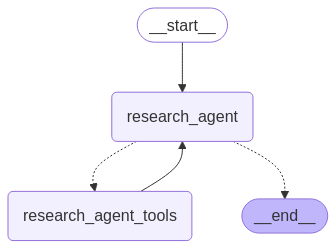

In [180]:
agent = research_builder.compile(name="research_agent")
display(Image(agent.get_graph(xray=1).draw_mermaid_png()))

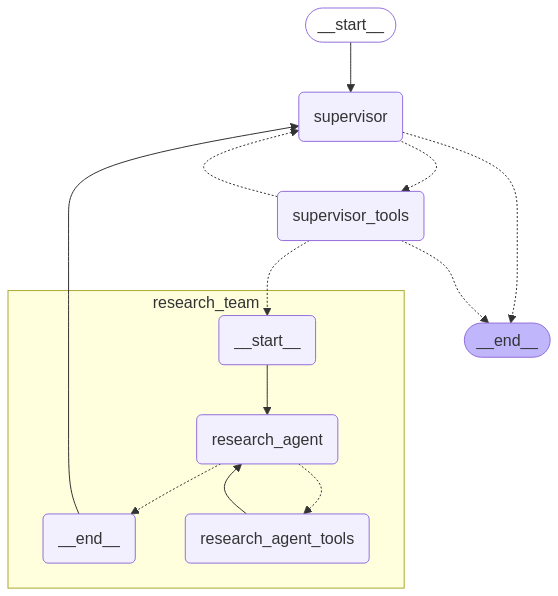

In [181]:
# Compile the supervisor agent
agent = supervisor_builder.compile(name="research_team")
display(Image(agent.get_graph(xray=1).draw_mermaid_png()))

In [182]:
import uuid 
from langgraph.checkpoint.memory import MemorySaver

# Checkpointer
checkpointer = MemorySaver()
agent = supervisor_builder.compile(name="research_team", checkpointer=checkpointer)

# Run the agent
thread_config = {"configurable": {"thread_id": uuid.uuid4()}}
msg =  [{"role": "user", "content": "What is model context protocol?"}]
# TODO: Why is response empty? Issue w/ invoke?
response = agent.invoke({"messages": msg}, config=thread_config)
for m in agent.get_state(thread_config).values['messages']:
    m.pretty_print()

================================ Human Message =================================

What is model context protocol?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_i7PMNtBPw5HMV44bry9kydrU)
 Call ID: call_i7PMNtBPw5HMV44bry9kydrU
  Args:
    query: Model Context Protocol architecture
    search_depth: advanced
================================= Tool Message =================================
Name: tavily_search

{'query': 'Model Context Protocol architecture', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': 'Specification - Model Context Protocol', 'url': 'https://spec.modelcontextprotocol.io/specification/draft/architecture/', 'content': 'Scroll to top\nSpecification\nSpecification (Draft)\nArchitecture\nArchitecture\nThe Model Context Protocol (MCP) follows a client-host-server architecture where each host can run multiple client instances. This architecture enables users to integrate AI c

In [183]:
msg =  [{"role": "user", "content": "Yes Anthropic‑backed open standard for integrating external context and tools with LLMs, architectural overview, tell me about interesting specific MCP servers, developer audience, just focus on MCP."}]
response = agent.invoke({"messages": msg}, config=thread_config)
for m in agent.get_state(thread_config).values['messages']:
    m.pretty_print()

================================ Human Message =================================

What is model context protocol?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_i7PMNtBPw5HMV44bry9kydrU)
 Call ID: call_i7PMNtBPw5HMV44bry9kydrU
  Args:
    query: Model Context Protocol architecture
    search_depth: advanced
================================= Tool Message =================================
Name: tavily_search

{'query': 'Model Context Protocol architecture', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': 'Specification - Model Context Protocol', 'url': 'https://spec.modelcontextprotocol.io/specification/draft/architecture/', 'content': 'Scroll to top\nSpecification\nSpecification (Draft)\nArchitecture\nArchitecture\nThe Model Context Protocol (MCP) follows a client-host-server architecture where each host can run multiple client instances. This architecture enables users to integrate AI c

In [184]:
from IPython.display import Markdown
Markdown(agent.get_state(thread_config).values['final_report'])

# Model Context Protocol: Architecture, Servers, and Developer Guide

Large‑language‑model (LLM) assistants are only as useful as the data and tools they can safely reach.  Anthropic’s Model Context Protocol (MCP) is an open‑standard answer to that integration problem.  Built on JSON‑RPC 2.0 and a simple client‑host‑server pattern, MCP lets any application expose *prompts*, *resources* and *tools* to an LLM through a stateful, capability‑negotiated session—no bespoke glue code required.

This report dives into MCP from a developer’s perspective.  We start by unpacking the core specification, then trace the lifecycle of a session, examine security guarantees, and explore how capability flags map to real transports.  We look at the three server primitives in depth, catalog the fast‑growing ecosystem of community and commercial MCP servers, and survey the official SDKs and adapters that streamline development.  A step‑by‑step tutorial shows how to build and deploy a custom server, while an integration section highlights patterns for plugging MCP into LangChain, IDEs and SaaS back‑ends.  We close with an analysis of current limitations and the forward roadmap.

Whether you are wiring an LLM into a Slack bot, exposing a database to Claude, or architecting a multi‑agent workflow, this guide aims to provide the architectural insight and hands‑on details you need to adopt MCP with confidence.

## Core Specification and Design Principles of MCP

The Model Context Protocol (MCP) defines a stateful, JSON‑RPC 2.0 message layer that lets AI “clients” and context‑providing “servers” exchange prompts, resources and tool calls.

Protocol foundation
- All traffic follows JSON‑RPC 2.0; three message types: request, response, notification.
- A connection begins with `initialize` → capability negotiation → `initialized`, forming a long‑lived session that supports progress, cancellation and ping utilities.
- Transport‑agnostic (stdio, HTTP, SSE); each client maintains one session per server.

Core features
- Server primitives: **prompts**, **resources**, **tools**; each advertised via capabilities and discoverable at runtime.
- Client features: **roots** (filesystem scopes) and **sampling** (server‑initiated LLM completions).  
- Capability flags gate optional functions (e.g., resource subscriptions).

Design goals (spec)
- **Simplicity** – servers focus on narrow tasks; hosts manage orchestration.
- **Composability** – multiple servers can be chained; any app may act as both client and server.
- **Security isolation** – servers cannot read full conversation or cross‑server data; host mediates context.
- **Progressive adoption** – features added independently; backwards compatibility via capability negotiation.

Why it matters
Anthropic positions MCP as the “universal connector” that eliminates N×M integrations, already backed by companies like Block and Replit, and an ecosystem of open‑source servers.

### Sources
1. https://spec.modelcontextprotocol.io/specification/2025-03-26/architecture/
2. https://spec.modelcontextprotocol.io/specification/2024-11-05/basic/
3. https://www.anthropic.com/news/model-context-protocol
4. https://medium.com/@nimritakoul01/the-model-context-protocol-mcp-a-complete-tutorial-a3abe8a7f4ef

## Client‑Host‑Server Architecture and Session Lifecycle

**Roles**
- **Host** – the LLM application (e.g., Claude Desktop, IDE plug‑ins) that spawns and supervises MCP clients, applies consent policies, and aggregates context.
- **Client** – a host‑internal process that maintains a 1:1, isolated JSON‑RPC connection to a single server; it negotiates capabilities and routes messages.
- **Server** – a lightweight program (local or remote) that exposes prompts, resources, or tools required by the model.

**Session phases (see architecture & lifecycle diagrams in the MCP specification)**
1. **Initialization**
   • Client → Server `initialize` request carrying `protocolVersion` and capability set.
   • Server → Client matching version & supported capabilities.
   • Client → Server `initialized` notification; secure stateful session begins.
2. **Message Exchange**
   • Bidirectional requests, responses, and notifications flow over JSON‑RPC.
   • Only features declared during negotiation may be used (e.g., tool calls, resource subscriptions, sampling).
   • Host enforces isolation across multiple concurrent client‑server pairs.
3. **Termination**
   • Either side sends `disconnect`/transport close; host cleans resources.
   • On shutdown, outstanding operations are cancelled and capability state is discarded.

**Host examples**
- Claude Desktop app (full MCP support: resources, prompts, tools).
- IDE assistants such as Continue (VS Code) or Zed editor integrating MCP for code workflows.

This architecture decouples responsibilities, simplifies security auditing, and lets features be added incrementally to servers or clients.

### Sources
1. https://modelcontextprotocol.io/specification/2025-03-26/architecture
2. https://modelcontextprotocol.io/docs/concepts/architecture
3. https://modelcontextprotocol.io/introduction

## Capability Negotiation & Transports

During the `initialize` handshake the client sends a `ClientCapabilities` object; the server replies with an `InitializeResult.capabilities` map.  Each key is a feature flag (e.g. `textDocumentSync`, `completionProvider`, `workspaceSymbolProvider`).  A missing key means “unsupported”, letting editors hide UI affordances and servers skip work.  Both sides can later refine support via `client/registerCapability` or `experimental` flags for preview features.  This light‑weight negotiation keeps 3rd‑party servers forward‑compatible with new spec releases.¹

LSP messages are JSON‑RPC 2.0 but the transport is pluggable:
• stdio (default): language process reads stdin / writes stdout; simple and cross‑platform.²  
• Node IPC / TCP socket: exposed by VS Code as `TransportKind.ipc` or `TransportKind.socket`; useful when the server runs as a long‑lived daemon.²  
• WebSocket: enables remote or browser‑based IDEs; the same JSON‑RPC frames travel inside WS frames (e.g. `vscode.websocket` sample).³  
• HTTP + Server‑Sent Events: some cloud gateways (e.g. GitHub Codespaces) tunnel LSP over HTTPS, still carrying the same headers and content.³

Because the spec forbids transport‑specific semantics, a server built for stdio usually works over WebSocket with only the launcher code changed—capability flags stay identical.

### Sources
1. https://github.com/Microsoft/language-server-protocol/blob/gh-pages/_specifications/lsp/3.17/specification.md
2. https://code.visualstudio.com/api/language-extensions/language-server-extension-guide
3. https://medium.com/ballerina-techblog/practical-guide-for-the-language-server-protocol-3091a122b750

## Security and Privacy Model

FHIR ecosystems layer multiple controls:

• Isolation boundaries – SMART‑on‑FHIR launches hand tokens to segregate the client, while FHIRcast adds unique hub.topic values and HMAC‑signed WebSub callbacks to prevent cross‑session data bleed. Hubs must reject unsecured HTTP and require opaque, unguessable callback URLs.

• Context scoping – Standard OAuth 2.0 scopes (e.g., patient/*.read, user/*.*) constrain the dataset exposed to each app; FHIRcast re‑uses these scopes per session, limiting events to the active patient or encounter.

• Consent workflows – The FHIR Consent resource stores granular rules (who, what, purpose). Authorization servers consult these records or downstream UMA/UDAP policies before issuing tokens, enabling patient‑directed or cascaded authorization across organisations.

• Encryption in transit – HL7 mandates TLS for all REST, WebSub and WebSocket channels; servers should refuse plaintext endpoints and may employ mutual‑TLS or JWT‑based client auth for business‑to‑business exchanges.

• Auditability – Every security‑relevant action is logged as an AuditEvent aligned with IHE‑ATNA. Entries capture who accessed which resource, outcome, and patient reference, supporting ONC certification, breach forensics and “accounting of disclosures” reports.

Together these mechanisms deliver traceable, consent‑aware sharing while containing PHI to the minimum necessary context.

### Sources
1. https://fhircast.org/security-considerations/
2. https://www.hl7.org/fhir/secpriv-module.html
3. https://kodjin.com/blog/fhir-audit-events/

## MCP Server Primitives: Prompts, Resources & Tools

MCP defines three primitives that an LLM‑aware server may expose:

- **Prompts (user‑controlled)** – reusable message templates chosen by users. Server must implement `list_prompts` and `get_prompt`; advertises capability `prompts` (+ optional `listChanged`).
- **Resources (app‑controlled)** – read‑only context URIs (e.g. `file://…`). Handlers are registered with `@mcp.resource(pattern)` and revealed through `list_resources`. Capability flag: `resources` (+ `subscribe`).
- **Tools (model‑controlled)** – side‑effecting functions callable by the model via `call_tool`. Registered with `@mcp.tool()`; exposed through `list_tools`. Capability flag: `tools` (+ `listChanged`).

Lifecycle
1. Registration at import time binds decorated functions to the FastMCP instance.
2. During `initialize`, the server sends a capability list so clients can discover available primitives.
3. At request time the SDK injects a `Context` object, giving access to progress, logging and `read_resource` helpers.
4. Optional `lifespan` callback starts/tears down shared state once per server run.

Sampling coordination
Clients may supply a `sampling_callback` that MCP forwards whenever the server needs the model to produce text for a prompt or tool chain, enabling streaming or instrumentation of generation.

```python
from mcp.server.fastmcp import FastMCP
mcp = FastMCP("Demo")
@mcp.prompt()
def greet(name:str):
    return f"Hello, {name}!"
@mcp.resource("config://app")
def cfg():
    return "v1"
@mcp.tool()
def add(a:int,b:int)->int:
    return a+b
```
### Sources
1. https://github.com/modelcontextprotocol/python-sdk
2. https://pypi.org/project/mcp/
3. https://ruslanmv.com/blog/Simple-MCP-Server-with-Python

## Catalog of Notable MCP Servers

• GitHub: Official server exposes issue search, pull‑request diff and repo metadata; ships with stdio & SSE transports, now in public preview with rewrite in Go, backed by GitHub engineering – signalling high production intent [1].

• Slack: Node‑based server lets LLMs list channels, post messages, reply, react and fetch user data. Supports npx or Docker launch (stdio/SSE) and requires OAuth bot token; MIT‑licensed and maintained in the core MCP repo (active since 2024) [2].

• Google Drive: Provides tools to search, read files and edit Sheets; resources map to gdrive:// URIs. Runs via Node + SSE, OAuth flow stores creds locally. Community project, forked from Anthropic code; small but evolving     [3].

• PostgreSQL: Read‑only database gateway that auto‑discovers schema resources and executes SELECT queries. Invoked with `npx @modelcontextprotocol/server-postgres` or Docker; widely used in IDEs like VS Code agent mode; MIT licence [4].

• Puppeteer: Browser automation server offering navigate, screenshot, click and evaluate tools plus console/screenshot resources. Headless Chromium via Docker or full browser via npx; allows custom launch options; part of official MCP servers, updated April 2025 [5].

• Time: Lightweight Python server returning current time and timezone conversions; async implementation, uvx or pip install; stable 0.6 release Dec 2024 [6].

### Sources
1. https://github.blog/changelog/2025-04-04-github-mcp-server-public-preview/
2. https://github.com/modelcontextprotocol/servers/blob/main/src/slack/README.md
3. https://github.com/isaacphi/mcp-gdrive
4. https://mcpservers.org/servers/modelcontextprotocol/postgres
5. https://github.com/modelcontextprotocol/servers/blob/main/src/puppeteer/README.md
6. https://github.com/modelcontextprotocol/servers/blob/main/src/time/README.md

## Developer Tooling and SDKs

• Official Python SDK (openai‑python) – 24 k★ GitHub library targeting Python 3.8+; auto‑generated from OpenAPI spec. Ships sync/async clients, SSE streaming, auto‑pagination, polling helpers (`*_and_poll`) and a CLI (`python -m openai chat …`). v1 rewrite (Nov 2023) added typed models, httpx transport and automatic retries.

• Official TypeScript/Node SDK (openai‑node) – 8.8 k★; provides comprehensive TS types, works in Node 18+, Deno, Bun and edge runtimes. Supports SSE streaming, WebSocket realtime API, file uploads via `toFile`, and pluggable `fetch` for custom logging, proxies or middleware. Error subclasses (`RateLimitError`, `APIConnectionError`, etc.) and `maxRetries` simplify resilient code.

• LangChain OpenAI Adapter – `langchain-openai` package exposes a drop‑in `ChatOpenAI` wrapper so LangChain chains can call the OpenAI SDK while remaining provider‑agnostic. Adapter mirrors `chat.completions.create` and streaming methods, easing model swaps during prototyping.

• Agents SDK (openai‑agents‑python) – 8.6 k★ framework that layers tracing, guardrails, function‑tool decorators and multi‑agent orchestration atop the Python SDK. Useful for testing complex workflows and inspecting runs via built‑in trace viewer.

Together these tools give developers typed APIs, CLI playgrounds, modern runtime support and higher‑level abstractions for rapid, testable OpenAI integrations.

### Sources
1. https://github.com/openai/openai-python
2. https://github.com/openai/openai-node
3. https://python.langchain.com/docs/integrations/adapters/openai/
4. https://github.com/openai/openai-agents-python

## Building a Custom MCP Server – Step‑by‑Step Guide

1. Scaffold
```ts
import { createServer } from '@anthropic-ai/mcp-js';
const server = createServer({
  name: 'weather-mcp',
  version: '1.0.0',
  capabilities: { tools:{}, resources:{}, prompts:{} }
});
server.listen(); // stdio transport
```

2. Capability design
• Tools: validate arguments with JSON Schema/Zod, return `{content:[…]}`.
• Resources: map stable URIs (e.g. `city://{name}`) and respond to `resources/read`.
• Prompts: expose templates via `prompts/get`, include argument metadata.

3. Robust error handling
• Wrap each handler in `try/catch`; throw JSON‑RPC errors so clients see codes.
• Write diagnostics to **stderr** only; stdout is reserved for protocol frames.
• Use `loggingNotification` with INFO‑ERROR levels for structured logs.

4. Deployment patterns
• Local: `npm link` / `pip install -e .` for instant stdio testing.
• Remote: expose SSE (`uvicorn.run(server.sse_app(), …)` or Spring Boot `spring-ai-starter-mcp-server-webmvc`).
• VM/Container: front with Nginx, force HTTPS, open only the SSE port.

5. Production best practices
• Require API keys or OAuth; add rate‑limits.
• Enable change notifications (`tool-change-notification=true`) so clients auto‑refresh.
• Keep payloads < 4 MB (`maxMessageSize`), monitor latency, and back‑off on 4xx/5xx.

### Sources
1. https://collabnix.com/how-to-build-and-host-your-own-mcp-servers-in-easy-steps/
2. https://docs.spring.io/spring-ai/reference/api/mcp/mcp-server-boot-starter-docs.html
3. https://medium.com/@logeshgcp/building-your-first-model-context-protocol-mcp-server-and-client-a-comprehensive-guide-a88d415e3dfb
4. https://modelcontextprotocol.io/docs/tools/debugging

## Integration Patterns for LLM Applications

MCP (Model Context Protocol) lets LLM agents call external tools through a uniform JSON‑RPC layer. Common integration routes:

• LangChain/ LangGraph: `langchain-mcp-adapters` wraps any MCP server as LangChain tools. A single line
```python
client = MultiServerMCPClient({"gmail": {...}, "math": {...}})
```
pulls schemas from many servers; routing logic inside the client selects the correct transport (stdio vs SSE URL) and exposes a merged toolset to the agent. [3]

• IDEs (Cursor, Zed, Replit, VS Code extensions such as Continue/Cline) embed an MCP client to surface file, git or terminal tools. The IDE forwards context (open file, cursor pos) and receives structured actions, enabling code edits or lint runs without custom per‑tool code. Early adopters report sharper context‑aware completion and autonomous refactors. [4]

• SaaS hosts (Composio) offer managed multi‑tenant MCP servers; developers only paste the server URL in the adapter. The agent automatically discovers >100 tools (Gmail, Trello, GitHub) and reasons which to invoke, dramatically cutting integration time. Step‑by‑step Node.js example clocks in under 50 lines. [1]

Design tips:
– Group servers by latency or auth domain; instantiate separate `MultiServerMCPClient`s to avoid cross‑tenant leakage.
– Use predictor‑based routing: let the LLM choose the `name` field that maps back to a target server/tool.
– Stream results via SSE for long‑running tasks while keeping quick math/FS ops on stdio.

### Sources
1. https://composio.dev/blog/langchain-mcp-adapter-a-step-by-step-guide-to-build-mcp-agents/
2. https://github.com/langchain-ai/langchain-mcp-adapters
3. https://daily.dev/blog/what-is-mcp-model-context-protocol


## Limitations, Challenges, and Future Roadmap

**Current limits**
- Context remains costly and imperfect: GPT‑4o handles 128 K; new GPT‑4.1 raises this to 1 M, yet benchmark recall stays <62 % and computer‑use accuracy 38 % (OSWorld) [1][2].
- Fragmented APIs: teams juggle Chat Completions, Assistants, and the just‑launched Responses API; Azure still lacks JSON/function support for vision calls, widening divergence [1][4].
- Hard ceilings: max 128 functions, 128 K tokens for many models, and Azure’s preview quotas throttle large‑scale RAG.

**Operational challenges**
- Spec churn forces rewrites; OpenAI plans to retire Assistants “first half 2026,” pushing developers to migrate again [2][3].
- Rolling model deprecations (e.g., monthly preview APIs, Turbo upgrades) demand constant retesting and budget resets [1][4].
- Built‑in tools (search, file, computer) add new per‑query fees and raise dependency on closed infrastructure.

**Roadmap signals**
- Responses API will absorb Assistants features, becoming the long‑term standard; Chat Completions continues for “stateless” use [2][3].
- More native tools—web search, vector RAG, computer‑use—expected, with server‑side state and tracing baked in [2].
- Context race: GPT‑4.1 family offers 1 M tokens, while Anthropic’s Claude 3 ships 200 K today and advertises “>1 M for select users,” hinting at multi‑million‑token competition [5].
- Enterprise asks (CMK, private VNet, batch discounts) appear monthly on Azure’s preview track, indicating ongoing parity work with OpenAI cloud [4].

Developers should design abstraction layers, monitor changelogs monthly, and budget for periodic migrations as the ecosystem converges on the Responses paradigm.

### Sources
1. https://platform.openai.com/docs/changelog
2. https://openai.com/index/new-tools-for-building-agents/
3. https://simonwillison.net/2025/Mar/11/responses-vs-chat-completions/
4. https://learn.microsoft.com/en-us/azure/ai-services/openai/whats-new
5. https://www.anthropic.com/news/claude-3-family

## Conclusion

The Model Context Protocol brings the rigor of well‑defined network standards to the messy world of LLM integrations.  By wrapping every external data source or action inside a small MCP server, developers gain a repeatable recipe for delivering fresh context to models while preserving security boundaries and auditability.  JSON‑RPC framing, capability negotiation, and a pluggable transport layer make the protocol easy to embed in desktop apps, cloud agents, and serverless back‑ends alike.

Key insights from this report:

• The client–host–server split cleanly isolates orchestration logic (host), model‑facing logic (client), and domain expertise (server), making each part independently testable and deployable.

• Prompts, resources, and tools form a minimal yet expressive surface for servers to expose capabilities.  Their tight coupling with capability flags ensures that models only see what they are allowed to use.

• A vibrant ecosystem of open‑source servers—spanning GitHub, Slack, Postgres, Puppeteer, weather feeds, and math helpers—demonstrates MCP’s versatility, while official SDKs and LangChain adapters lower the barrier to entry.

• Security considerations are first‑class: context scoping, per‑server isolation, consent workflows, and transport‑level encryption help organizations comply with privacy regulations without stifling innovation.

• Remaining challenges include standardized authentication, context‑window budgeting across many servers, and maintaining backward compatibility as the spec evolves.  The published roadmap and open governance model position MCP to tackle these issues collaboratively.

For developers building agentic systems or enterprise copilots, adopting MCP now offers a strategic advantage: you can focus on higher‑value reasoning and product logic while delegating data plumbing to a growing catalogue of interchangeable, community‑maintained connectors.  As the protocol matures, expect MCP to become as foundational to AI tooling as HTTP is to web services.